# Import libraries

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
import sys

In [2]:
from scripts.parse_vars import parse_variables

In [3]:
path_vars = f"../../geno_simulation.txt"
R_directory = f"../../rstudio_geno_simulation"
R_file = f"create_geno.R"

variables = parse_variables(path_vars)
if 'G' not in globals():
    G = int(variables['G'])
if 'L' not in globals():
    L = int(variables['L'])
if 'c' not in globals():
    c = int(variables['c'])
if 'k' not in globals():
    k = int(variables['k'])
if 'M' not in globals():
    M = float(variables['M'])
if 'HWE' not in globals():
    HWE = int(variables['HWE'])

if 'tools' not in globals():
    tools = ['PCA', 'abyss_counted', 'abyss', 'no_corr']


if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(variables['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(variables['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(variables['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(variables['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(variables['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(variables['common_threshold_H'])
if 'F' not in globals():
    F = float(variables['F'])
commands = [
    f"G <- {G}",
    f"L <- {L}",
    f"c <- {c}",
    f"k <- {k}",
    f"M <- {M}",
    f'setwd("{R_directory}")',
    f'source("{R_file}", echo=TRUE)'
]


# Concatenate commands into a single string
r_script = ";".join(commands)

# Run the R script
result = subprocess.run(['Rscript', '-e', r_script], capture_output=True, text=True)


In [4]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/genotype"
geno = pd.read_pickle((f"{path_geno}/complete_inbred.pkl"))

In [5]:
geno

,C_1_MAF_0.500,C_2_MAF_0.500,C_3_MAF_0.500,C_4_MAF_0.500,C_5_MAF_0.500,C_6_MAF_0.500,C_7_MAF_0.499,C_8_MAF_0.499,C_9_MAF_0.499,C_10_MAF_0.499,...,VR_3991_MAF_0.045,VR_3992_MAF_0.044,VR_3993_MAF_0.044,VR_3994_MAF_0.044,VR_3995_MAF_0.044,VR_3996_MAF_0.043,VR_3997_MAF_0.043,VR_3998_MAF_0.042,VR_3999_MAF_0.042,VR_4000_MAF_0.042
0,1,1,-1,1,-1,-1,1,1,-1,-1,...,1,1,1,1,1,1,0,1,1,1
1,1,1,-1,1,0,0,1,1,-1,-1,...,1,1,1,1,1,1,1,1,0,1
2,1,1,-1,1,-1,-1,1,1,-1,0,...,1,1,1,1,1,1,1,1,1,1
3,1,1,-1,1,-1,-1,1,1,0,-1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,0,1,-1,-1,1,1,-1,-1,...,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1,1,1,0,1,-1,-1,1,0,0,...,1,1,1,1,0,1,1,1,1,1
1996,-1,1,1,-1,1,-1,-1,1,1,-1,...,1,1,1,0,1,1,1,1,1,1
1997,-1,1,1,-1,1,1,-1,1,1,-1,...,1,1,1,0,1,1,1,1,1,1
1998,-1,0,1,-1,1,-1,-1,1,1,-1,...,1,1,0,1,0,1,1,1,1,0


In [6]:
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
pheno = pd.read_pickle(f"{path_pheno}/env_pheno.pkl")
humans = pd.read_pickle(f"{path_pheno}/inbred_humans.pkl")

# PCA

In [12]:
from sklearn.preprocessing import StandardScaler

# Standardize each SNP (column): zero mean, unit variance
scaler = StandardScaler()
X_std = scaler.fit_transform(geno.values)

In [13]:
from sklearn.decomposition import PCA

# Run PCA and extract, say, top 10 components
pca = PCA(n_components=10)
pcs = pca.fit_transform(X_std)

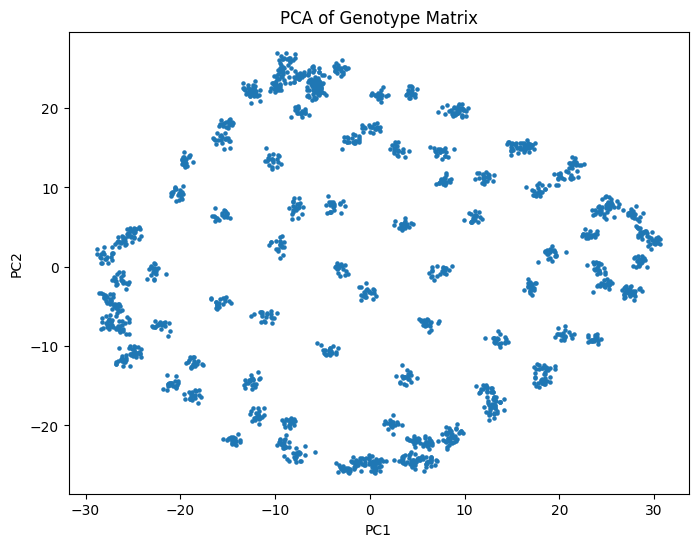

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pcs[:, 0], X_pcs[:, 1], s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Genotype Matrix")
plt.show()


In [15]:
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.06586123 0.05960183 0.03216571 0.02371215 0.02127445 0.01729589
 0.01624351 0.01266337 0.01198757 0.01171509]


# Gwas

In [16]:
from statsmodels.api import OLS, add_constant
import numpy as np
import pandas as pd

# Extract phenotype
y = pheno[env_factor].values

# Assume 'pcs' is a NumPy array or DataFrame with shape (n_samples, n_pcs)
# If it's a NumPy array, convert to DataFrame
pcs_df = pd.DataFrame(pcs, columns=[f'PC{i+1}' for i in range(pcs.shape[1])])

# Initialize results list
results = []

# Loop through SNPs
for snp in geno.columns:
    x = geno[snp].values
    # Combine SNP with PCs
    X = pd.concat([pd.Series(x, name='SNP'), pcs_df], axis=1)
    X = add_constant(X)  # Add intercept
    model = OLS(y, X).fit()
    pval = model.pvalues['SNP']  # p-value for SNP term
    logp = -np.log10(pval)
    results.append((snp, logp))

# Create and sort results DataFrame
gwas_results = pd.DataFrame(results, columns=['SNP', '-log10(p)'])
gwas_results = gwas_results.sort_values('-log10(p)', ascending=False).reset_index(drop=True)

# Display
gwas_results


,SNP,-log10(p)
0,C_1056_MAF_0.225,61.836758
1,C_1117_MAF_0.218,59.419999
2,C_1099_MAF_0.219,55.312156
3,C_1110_MAF_0.218,54.454809
4,C_161_MAF_0.462,53.719078
...,...,...
3995,VR_3872_MAF_0.050,0.001201
3996,R_3435_MAF_0.057,0.000748
3997,R_1982_MAF_0.126,0.000665
3998,R_1913_MAF_0.130,0.000570


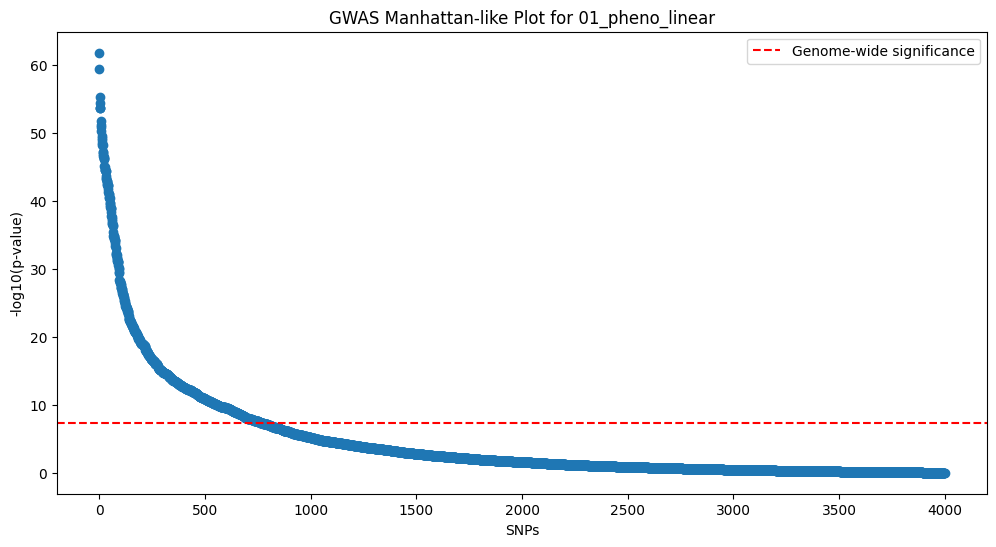

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(gwas_results['-log10(p)'].values, marker='o', linestyle='none')
plt.axhline(-np.log10(5e-8), color='red', linestyle='--', label='Genome-wide significance')
plt.xlabel('SNPs')
plt.ylabel('-log10(p-value)')
plt.title(f'GWAS Manhattan-like Plot for {env_factor}')
plt.legend()
plt.show()

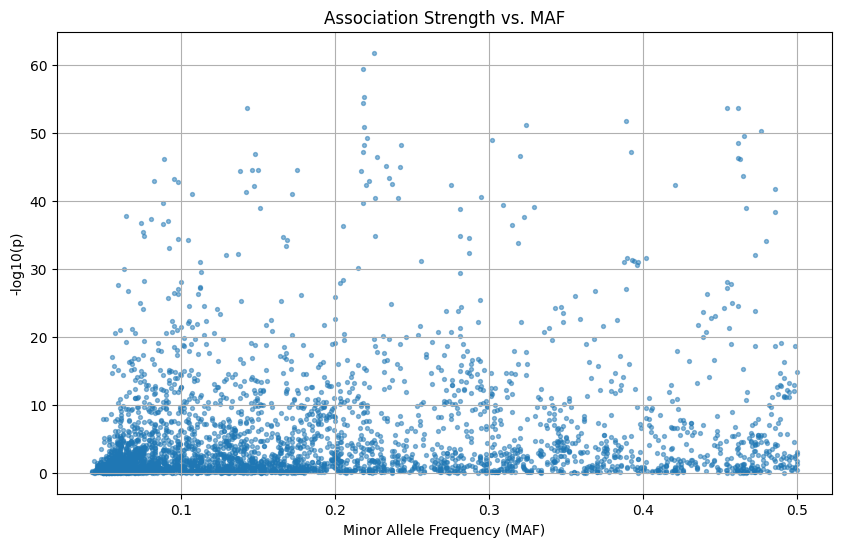

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: your GWAS results DataFrame
# Columns: ['SNP', '-log10(p)']
# Extract MAF from SNP names
gwas_results['MAF'] = gwas_results['SNP'].str.extract(r'MAF_([\d.]+)').astype(float)

# Plot MAF vs -log10(p)
plt.figure(figsize=(10, 6))
plt.scatter(gwas_results['MAF'], gwas_results['-log10(p)'], alpha=0.5, s=8)
plt.xlabel("Minor Allele Frequency (MAF)")
plt.ylabel("-log10(p)")
plt.title("Association Strength vs. MAF")
plt.grid(True)
plt.show()
